In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark=(SparkSession.builder.appName('SparkSQL').getOrCreate())

In [4]:
tweet = (spark.read.format('csv')
         .option('inferSchema', 'true')
         .option('header', 'false')
         .load('file:///home/hduser/Downloads/ProjectTweets.csv')
         .toDF('ID', 'ID1', 'Date', 'Flag', 'User', 'Text'))

In [5]:
tweet.show()

+---+----------+--------------------+--------+---------------+--------------------+
| ID|       ID1|                Date|    Flag|           User|                Text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [6]:
tweet.createOrReplaceTempView('Tweets')

In [7]:
spark.sql('SELECT Date, Text FROM Tweets').show(5)

+--------------------+--------------------+
|                Date|                Text|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|@switchfoot http:...|
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
+--------------------+--------------------+
only showing top 5 rows



In [8]:
tweet.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- ID1: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Text: string (nullable = true)



In [9]:
from pyspark.sql.functions import lower

tweet = tweet.withColumn("Text", lower(tweet["Text"]))


In [10]:
#pip install --upgrade numpy==1.24.3 

In [11]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol='Text', outputCol='Text1')
tweet = tokenizer.transform(tweet)

In [12]:
from pyspark.ml.feature import StopWordsRemover

remover= StopWordsRemover(inputCol='Text1', outputCol='Text2')
tweet = remover.transform(tweet)

In [13]:
tweet.select("Text", "Text1", 'Text2').show()

+--------------------+--------------------+--------------------+
|                Text|               Text1|               Text2|
+--------------------+--------------------+--------------------+
|@switchfoot http:...|[@switchfoot, htt...|[@switchfoot, htt...|
|is upset that he ...|[is, upset, that,...|[upset, update, f...|
|@kenichan i dived...|[@kenichan, i, di...|[@kenichan, dived...|
|my whole body fee...|[my, whole, body,...|[whole, body, fee...|
|@nationwideclass ...|[@nationwideclass...|[@nationwideclass...|
|@kwesidei not the...|[@kwesidei, not, ...|[@kwesidei, whole...|
|         need a hug |      [need, a, hug]|         [need, hug]|
|@loltrish hey  lo...|[@loltrish, hey, ...|[@loltrish, hey, ...|
|@tatiana_k nope t...|[@tatiana_k, nope...|  [@tatiana_k, nope]|
|@twittera que me ...|[@twittera, que, ...|[@twittera, que, ...|
|spring break in p...|[spring, break, i...|[spring, break, p...|
|i just re-pierced...|[i, just, re-pier...|  [re-pierced, ears]|
|@caregiving i cou...|[@c

In [14]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

def get_sentiment(text):
    text_str = str(text)
    analysis = TextBlob(text_str)
    return analysis.sentiment.polarity

sentiment_udf = udf(get_sentiment, FloatType())
tweet = tweet.withColumn('Sentiment', sentiment_udf('Text1'))

tweet.select('Text1', 'Sentiment').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|Text1                                                                                                                                        |Sentiment  |
+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[@switchfoot, http://twitpic.com/2y1zl, -, awww,, that's, a, bummer., , you, shoulda, got, david, carr, of, third, day, to, do, it., ;d]     |0.2        |
|[is, upset, that, he, can't, update, his, facebook, by, texting, it..., and, might, cry, as, a, result, , school, today, also., blah!]       |0.0        |
|[@kenichan, i, dived, many, times, for, the, ball., managed, to, save, 50%, , the, rest, go, out, of, bounds]                                |0.5        |
|[my, whole, body, feels, itchy, and, like, its, on, fire]      

In [15]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import StringType

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] > 0.3:
        return 'Positive'
    elif sentiment['compound'] < -0.3:
        return 'Negative'
    else:
        return 'Neutral'
    
sentiment_udf = udf(analyze_sentiment, StringType())

tweet = tweet.withColumn('Polarity', sentiment_udf('Text2'))

tweet.select('Sentiment', 'Polarity').show(truncate=False)

+-----------+--------+
|Sentiment  |Polarity|
+-----------+--------+
|0.2        |Neutral |
|0.0        |Negative|
|0.5        |Positive|
|0.2        |Neutral |
|-0.625     |Negative|
|0.2        |Neutral |
|0.0        |Positive|
|0.27083334 |Positive|
|0.0        |Neutral |
|0.0        |Neutral |
|-0.21428572|Neutral |
|0.0        |Neutral |
|0.0        |Negative|
|0.0        |Neutral |
|0.075      |Negative|
|0.0        |Positive|
|0.0        |Negative|
|0.0        |Neutral |
|0.78125    |Positive|
|0.0        |Neutral |
+-----------+--------+
only showing top 20 rows



In [17]:
from pyspark.sql.functions import to_date

tweet = tweet.withColumn("Date", to_date(tweet["Date"]))

In [24]:
from pyspark.sql.functions import avg
daytweet = tweet.groupBy(col("Date").alias("day")).agg(avg("Sentiment").alias("avg_Sentiment"))

In [ ]:
daytweet.show()

In [17]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="Text2", 
                     outputCol="Features", 
                     vocabSize=3, 
                     minDF=1.0)

In [18]:
model = cv.fit(tweet)
result = model.transform(tweet)

In [19]:
result.select("Features").show(truncate=False)

+-------------+
|Features     |
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[0],[2.0])|
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[0],[3.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[0],[1.0])|
|(3,[],[])    |
+-------------+
only showing top 20 rows



In [20]:
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

label_indexer = StringIndexer(inputCol="User", outputCol="Label_Index").fit(tweet)
df = label_indexer.transform(tweet)

In [21]:
hashingTF = HashingTF(inputCol="Text2", outputCol="Raw_Features", numFeatures=20)
idf = IDF(inputCol="Raw_Features", outputCol="features")
pipeline = Pipeline(stages=[hashingTF, idf])

In [22]:
model = pipeline.fit(df)
df = model.transform(df)

In [23]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=1234)

In [24]:
nb = NaiveBayes(featuresCol="features", 
                labelCol="Label_Index", 
                predictionCol="prediction", 
                smoothing=1.0, 
                modelType="multinomial")
nb_model = nb.fit(trainingData)

2023-11-15 13:12:40,546 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.6 MiB
2023-11-15 13:20:40,917 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.5 MiB


In [25]:
spark = SparkSession.builder.config("spark.network.timeout", "600s").getOrCreate()

In [26]:
predictions = nb_model.transform(testData)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label_Index", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = {:.2f}%".format(accuracy * 100))

2023-11-15 13:21:33,614 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 116.9 MiB
2023-11-15 13:22:52,623 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:22:53,813 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:22:54,753 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:22:55,478 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:22:56,012 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:23:33,902 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:23:34,445 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:23:34,959 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-15 13:24:59,843 

In [30]:
#tweets = tweet.toPandas() #(Could not convert pyspark dataframe into pandas dataframe)

In [1]:
import pandas as pd

In [2]:
tweet = pd.read_csv('ProjectTweets.csv')

In [3]:
tweet.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
tweet.tail()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1599994,1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
tweet.columns = ['ID', 'ID1', 'Date', 'Flag', 'User', 'Text']

In [6]:
tweet.head()

,ID,ID1,Date,Flag,User,Text
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
tweet.dtypes

ID       int64
ID1      int64
Date    object
Flag    object
User    object
Text    object
dtype: object

In [8]:
print(tweet.isnull().sum())

ID      0
ID1     0
Date    0
Flag    0
User    0
Text    0
dtype: int64


In [9]:
#pip install skforecast

In [10]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
tweet['Flag'].unique()

array(['NO_QUERY'], dtype=object)

In [12]:
tweet.drop(['ID', 'Flag'], axis=1, inplace=True)

In [13]:
tweet['Date']=tweet['Date'].str.replace('PDT', '', regex=False)

In [14]:
tweet.head()

,ID1,Date,User,Text
0,1467810672,Mon Apr 06 22:19:49 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 2009,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 2009,joy_wolf,@Kwesidei not the whole crew


In [15]:
tweet['Date']=pd.to_datetime(pd.Series(tweet['Date']))
tweet['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

0          2009-04-06 22:19:49
1          2009-04-06 22:19:53
2          2009-04-06 22:19:57
3          2009-04-06 22:19:57
4          2009-04-06 22:20:00
                  ...         
1599994    2009-06-16 08:40:49
1599995    2009-06-16 08:40:49
1599996    2009-06-16 08:40:49
1599997    2009-06-16 08:40:49
1599998    2009-06-16 08:40:50
Name: Date, Length: 1599999, dtype: object

In [16]:
tweet.head()

,ID1,Date,User,Text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


In [17]:
#pip install nltk

In [18]:
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def get_text_processing(Text):
    stpword=stopwords.words('english')
    no_punctuation=[char for char in Text if char not in string.punctuation]
    no_punctuation=''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [20]:
tweet['Review']=tweet['Text'].apply(get_text_processing)

In [21]:
#pip install textblob

In [22]:
from textblob import TextBlob

In [23]:
def get_sentiment(Text):
    analysis=TextBlob(Text)
    return analysis.sentiment.polarity

In [24]:
tweet['Sentiment']=tweet['Review'].apply(get_sentiment)

In [25]:
tweet.head()

,ID1,Date,User,Text,Review,Sentiment
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update Facebook texting might cry r...,0.000
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan dived many times ball Managed save 50...,0.500
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,0.200
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see,-0.625
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew,Kwesidei whole crew,0.200


In [26]:
tweet.drop(['ID1', 'User', 'Text'], axis=1, inplace=True)

In [27]:
tweet['Rating'] = tweet['Sentiment'].apply(lambda x:'Positive' if x>0.3 
                                           else ('Negavtive'if x<-0.3 else 'Neutral'))

In [28]:
tweet.head()

,Date,Review,Sentiment,Rating
0,2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
1,2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2,2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
3,2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
4,2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [29]:
import seaborn as sns

/tmp/ipykernel_16178/3720026483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=tweet, palette='summer')


<AxesSubplot:xlabel='Rating', ylabel='count'>

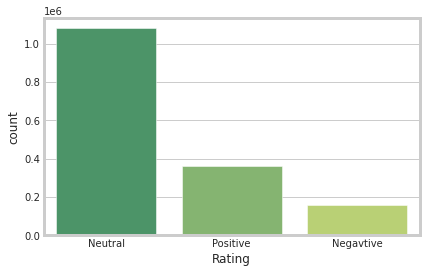

In [30]:
sns.set_style('whitegrid')
sns.countplot(x='Rating', data=tweet, palette='summer')

In [31]:
tweet = tweet.set_index('Date')

In [37]:
tweet.head()

,Review,Sentiment,Rating
Date,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [38]:
time = tweet[['Sentiment']].copy()

In [39]:
time.reset_index(inplace=True)

In [40]:
time.head()

,Date,Sentiment
0,2009-04-06 22:19:49,0.000
1,2009-04-06 22:19:53,0.500
2,2009-04-06 22:19:57,0.200
3,2009-04-06 22:19:57,-0.625
4,2009-04-06 22:20:00,0.200


In [41]:
time = time.set_index('Date')

In [42]:
time.head()

,Sentiment
Date,
2009-04-06 22:19:49,0.000
2009-04-06 22:19:53,0.500
2009-04-06 22:19:57,0.200
2009-04-06 22:19:57,-0.625
2009-04-06 22:20:00,0.200


In [44]:
tweet.head()

,Review,Sentiment,Rating
Date,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [46]:
tweet.drop(['Sentiment'], axis=1, inplace=True)

In [47]:
one_hot = pd.get_dummies(tweet["Rating"])
tweet.drop(['Rating'],axis=1,inplace=True)
tweet = pd.concat([tweet,one_hot],axis=1)
tweet.head()

,Review,Negavtive,Neutral,Positive
Date,,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,False,True,False
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,False,False,True
2009-04-06 22:19:57,whole body feels itchy like fire,False,True,False
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,True,False,False
2009-04-06 22:20:00,Kwesidei whole crew,False,True,False


In [68]:
tweet.reset_index(drop=True, inplace=True)

In [75]:
tweet['Negavtive'] = tweet['Negavtive'].astype(int)
tweet['Neutral'] = tweet['Neutral'].astype(int)
tweet['Positive'] = tweet['Positive'].astype(int)

In [69]:
tweet.shape

(1599999, 4)

In [76]:
tweet.head()

,Review,Negavtive,Neutral,Positive
0,upset cant update Facebook texting might cry r...,0,1,0
1,Kenichan dived many times ball Managed save 50...,0,0,1
2,whole body feels itchy like fire,0,1,0
3,nationwideclass behaving im mad cant see,1,0,0
4,Kwesidei whole crew,0,1,0


In [77]:
from sklearn.model_selection import train_test_split
X = tweet['Review'].values
y = tweet.drop('Review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
#sparse_tensor = ...
import tensorflow as tf
#if not tf.debugging.check_numerics(tf.sort(sparse_tensor.indices, axis=-1), 'Invalid indices order'):
    #reordered_sparse_tensor = tf.sparse.reorder(sparse_tensor)
#else:
    #reordered_sparse_tensor = sparse_tensor
    

model = Sequential()

model.add(Dense(units=1067333,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=40000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=5000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit(x=X_train, y=y_train, batch_size=2560, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

2023-11-14 23:32:49.429053: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at serialize_sparse_op.cc:389 : INVALID_ARGUMENT: indices[1] = [0,288436] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.




InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,288436] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse] name: 

In [ ]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
preds.shape

In [82]:
time.head()

,Sentiment
Date,
2009-04-06 22:19:49,0.000
2009-04-06 22:19:53,0.500
2009-04-06 22:19:57,0.200
2009-04-06 22:19:57,-0.625
2009-04-06 22:20:00,0.200


In [83]:
(time.index == pd.date_range(start=time.index.min(),
                             end=time.index.max(),
                             freq=time.index.freq)).all()

ValueError: Lengths must match to compare

In [88]:
time.index = pd.to_datetime(time.index)
dtime = time.resample('D').size().reset_index(name='count')

In [90]:
time.index = pd.to_datetime(time.index)
dtime = time.resample('D').mean().reset_index()

In [91]:
dtime

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN
...,...,...
76,2009-06-21,0.003373
77,2009-06-22,-0.024647
78,2009-06-23,-0.016030
79,2009-06-24,-0.014245


In [92]:
print(dtime.isnull().sum())

Date          0
Sentiment    33
dtype: int64


In [98]:
time_linear_interpolation = dtime.interpolate(method='linear')

In [99]:
dtime.interpolate(method='linear', inplace=True)

In [100]:
dtime

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,0.101622
3,2009-04-09,0.103854
4,2009-04-10,0.106085
...,...,...
76,2009-06-21,0.003373
77,2009-06-22,-0.024647
78,2009-06-23,-0.016030
79,2009-06-24,-0.014245


In [101]:
print(dtime.isnull().sum())

Date         0
Sentiment    0
dtype: int64


In [102]:
dtime = dtime.set_index('Date')

In [103]:
(dtime.index == pd.date_range(start=dtime.index.min(),
                             end=dtime.index.max(),
                             freq=dtime.index.freq)).all()

True

Train dates : 2009-04-06 00:00:00 --- 2009-06-10 00:00:00  (n=66)
Test dates  : 2009-06-11 00:00:00 --- 2009-06-25 00:00:00  (n=15)


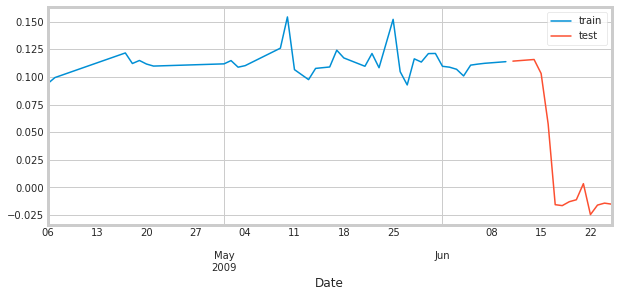

In [106]:
steps = 15
dtime_train = dtime[:-steps]
dtime_test  = dtime[-steps:]

print(f"Train dates : {dtime_train.index.min()} --- {dtime_train.index.max()}  (n={len(dtime_train)})")
print(f"Test dates  : {dtime_test.index.min()} --- {dtime_test.index.max()}  (n={len(dtime_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train')
dtime_test['Sentiment'].plot(ax=ax, label='test')
ax.legend();

In [107]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=dtime_train['Sentiment'])
forecaster

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 65] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-14 23:51:28 
Last fit date: 2023-11-14 23:51:28 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [108]:
steps = 15
predictions = forecaster.predict(steps=steps)
predictions.head(5)

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


6     0.115862
7     0.117686
8     0.119138
9     0.119190
10    0.115782
Name: pred, dtype: float64

TypeError: index type not supported

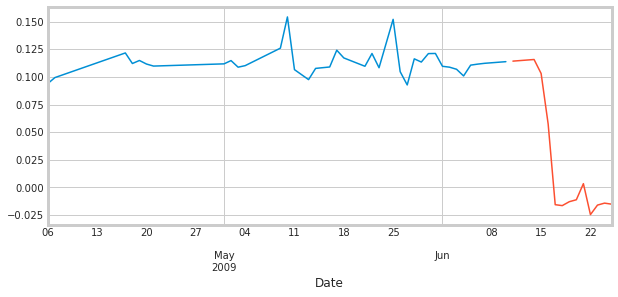

In [109]:
fig, ax = plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train')
dtime_test['Sentiment'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [111]:
error_mse = mean_squared_error(
                y_true = dtime_test['Sentiment'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.010346302226309632


In [113]:
steps = 15
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = dtime_train['Sentiment'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(dtime_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


AttributeError: 'FloatProgress' object has no attribute 'style'

In [1]:
mongo_uri = "mongodb://localhost:27017/databases.twitter"